In [1]:
!pip install duckdb --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
!pip install polars --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg

Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg


In [1]:
import numpy as np
import pandas as pd
import os
import duckdb as dd
import polars as pl
import h5py

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/cafa-6-protein-function-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cafa-6-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-6-protein-function-prediction/IA.tsv
/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta
/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset-taxon-list.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo


In [13]:
protein_accession_ids = []
protein_embeddings = []

with h5py.File("/kaggle/input/suman-uniprot-swissprot-embeds/per-protein.h5", "r") as file:
    print(f"number of entries: {len(file.keys())}")
    for sequence_id in file.keys():
        protein_accession_ids.append(sequence_id)
        embedding_data = file[sequence_id][()] 
        protein_embeddings.append(embedding_data)

emb_df = pd.DataFrame({
    'protein_accession_id': protein_accession_ids,
    'protein_embedding': protein_embeddings
})

emb_df.to_parquet('protein_embeddings.parquet')

number of entries: 573650


In [3]:
emb_df = pl.read_parquet('/kaggle/input/suman-uniprot-swissprot-embeds/protein_embeddings.parquet')
emb_df.shape

(573650, 2)

In [4]:
emb_df.head(3)

protein_accession_id,protein_embedding
str,list[f32]
"""A0A009IHW8""","[0.068115, -0.046478, … -0.031021]"
"""A0A011QK89""","[0.003136, 0.023239, … 0.02655]"
"""A0A017SE81""","[0.013115, -0.029724, … 0.000838]"


In [5]:
train_terms_df = pl.read_csv('/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv', separator='\t')
train_terms_df.shape

(537027, 3)

In [6]:
train_terms_df.head(3)

EntryID,term,aspect
str,str,str
"""Q5W0B1""","""GO:0000785""","""C"""
"""Q5W0B1""","""GO:0004842""","""F"""
"""Q5W0B1""","""GO:0051865""","""P"""


In [8]:
train_terms_w_embeds = dd.sql("select distinct t1.protein_accession_id, t2.term, t2.aspect, t1.protein_embedding \
from emb_df t1 \
join train_terms_df t2 \
on t1.protein_accession_id = t2.EntryID").pl()

train_terms_w_embeds.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(536906, 4)

In [9]:
train_terms_w_embeds.head(3)

protein_accession_id,term,aspect,protein_embedding
str,str,str,list[f32]
"""Q9FL33""","""GO:0005515""","""F""","[0.02388, 0.024994, … 0.005478]"
"""Q24368""","""GO:0140750""","""F""","[0.039001, 0.052643, … -0.013039]"
"""Q24368""","""GO:0006325""","""P""","[0.039001, 0.052643, … -0.013039]"


In [23]:
dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_w_embeds").pl()

uniq_protein_accession_ids
i64
82396


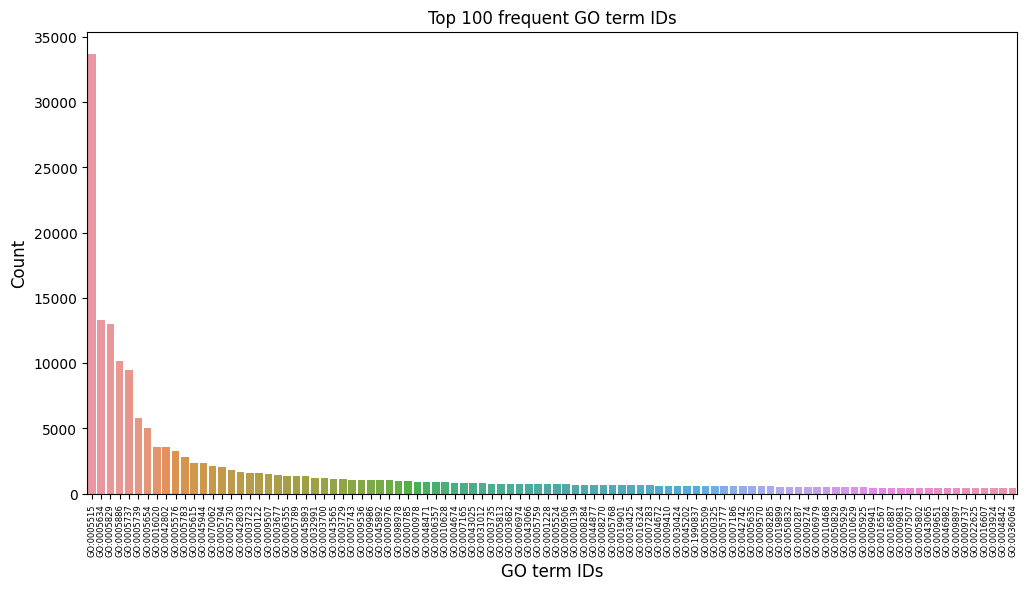

In [16]:
# Select first 1500 values for plotting
plot_df = dd.sql("select term, count(1) as freq from train_terms_w_embeds group by term order by count(1) desc limit 100").pl()
plot_df_pandas = plot_df.to_pandas()

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=plot_df_pandas.term, y=plot_df_pandas.freq)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [20]:
num_of_labels = 3000

query = "select term, count(1) as freq from train_terms_w_embeds group by term order by count(1) desc limit {0}".format(num_of_labels)

filtered_labels = dd.sql(query).pl()
labels_list = filtered_labels['term'].to_list()

# Take value counts in descending order and fetch first 3000 `GO term ID` as labels
train_labels = train_terms_w_embeds.filter(pl.col("term").is_in(labels_list))
train_labels.shape

(397978, 4)

In [21]:
train_labels.head(4)

protein_accession_id,term,aspect,protein_embedding
str,str,str,list[f32]
"""Q9FL33""","""GO:0005515""","""F""","[0.02388, 0.024994, … 0.005478]"
"""Q24368""","""GO:0006325""","""P""","[0.039001, 0.052643, … -0.013039]"
"""Q9P940""","""GO:0030446""","""C""","[0.050232, -0.004929, … 0.026199]"
"""Q9JMB7""","""GO:0003727""","""F""","[0.006416, 0.024399, … 0.004128]"


In [22]:
dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_labels").pl()

uniq_protein_accession_ids
i64
78525


In [24]:
train_protein_labels = train_labels.select(['protein_accession_id','term'])
train_protein_labels.head(5)

protein_accession_id,term
str,str
"""Q9FL33""","""GO:0005515"""
"""Q24368""","""GO:0006325"""
"""Q9P940""","""GO:0030446"""
"""Q9JMB7""","""GO:0003727"""
"""Q10312""","""GO:0005829"""


In [28]:
train_protein_labels_w_term_presence = train_protein_labels.with_columns(
    pl.lit(1.0).alias("presence")
)

pivoted_df = train_protein_labels_w_term_presence.pivot(
    index="protein_accession_id",
    on="term",
    values="presence",  
    aggregate_function="sum"
)

pivoted_df = pivoted_df.fill_null(0)

In [29]:
pivoted_df.head(5)

protein_accession_id,GO:0005515,GO:0006325,GO:0030446,GO:0003727,GO:0005829,GO:0032760,GO:0031669,GO:0031505,GO:0046512,GO:0004252,GO:0005509,GO:0007271,GO:0005654,GO:0009408,GO:0003712,GO:0000976,GO:0003729,GO:0002020,GO:0042802,GO:0019901,GO:0006412,GO:0005886,GO:0050766,GO:0009274,GO:0030742,GO:0003723,GO:0005739,GO:0004860,GO:0035251,GO:0051276,GO:0016607,GO:0044182,GO:0005634,GO:0022627,GO:0048471,GO:0071333,…,GO:0005977,GO:0005539,GO:0097216,GO:0007435,GO:0009743,GO:0042100,GO:2000781,GO:0034704,GO:1903076,GO:0030955,GO:0006836,GO:0031045,GO:1990110,GO:0000164,GO:0036342,GO:0038061,GO:0003676,GO:0016407,GO:0090351,GO:0016266,GO:0045492,GO:0033120,GO:0000212,GO:0008589,GO:0005656,GO:0051968,GO:0008157,GO:0005677,GO:1900017,GO:0005536,GO:0000387,GO:0009609,GO:0042573,GO:0051899,GO:0009252,GO:0071555,GO:0009051
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Q9FL33""",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Q24368""",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Q9P940""",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Q9JMB7""",1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Q10312""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
train_protein_features = train_labels.select(['protein_accession_id','protein_embedding'])
train_protein_features.head(5)

protein_accession_id,protein_embedding
str,list[f32]
"""Q9FL33""","[0.02388, 0.024994, … 0.005478]"
"""Q24368""","[0.039001, 0.052643, … -0.013039]"
"""Q9P940""","[0.050232, -0.004929, … 0.026199]"
"""Q9JMB7""","[0.006416, 0.024399, … 0.004128]"
"""Q10312""","[-0.007023, -0.041382, … -0.050018]"


In [31]:
train_protein_features_flattened = train_protein_features.with_columns(
    # Convert the list to a struct, which gives anonymous field names like 'field_0', 'field_1', etc.
    pl.col("protein_embedding").list.to_struct()
).unnest(
    # Unnest the 'protein_embedding' struct column into individual columns
    "protein_embedding"
)

train_protein_features_flattened.shape

/tmp/ipykernel_37/2367105210.py:3: UserWarning: `to_struct()` should be passed a list of field names to avoid query errors in subsequent operations (e.g. <struct operation> not supported for dtype Unknown)
  pl.col("protein_embedding").list.to_struct()


(397978, 1025)

In [32]:
train_protein_features_flattened.head(5)

protein_accession_id,field_0,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,field_11,field_12,field_13,field_14,field_15,field_16,field_17,field_18,field_19,field_20,field_21,field_22,field_23,field_24,field_25,field_26,field_27,field_28,field_29,field_30,field_31,field_32,field_33,field_34,field_35,…,field_987,field_988,field_989,field_990,field_991,field_992,field_993,field_994,field_995,field_996,field_997,field_998,field_999,field_1000,field_1001,field_1002,field_1003,field_1004,field_1005,field_1006,field_1007,field_1008,field_1009,field_1010,field_1011,field_1012,field_1013,field_1014,field_1015,field_1016,field_1017,field_1018,field_1019,field_1020,field_1021,field_1022,field_1023
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""Q9FL33""",0.02388,0.024994,-0.018997,0.04129,-0.014961,-0.015366,-0.048645,-0.082581,-0.004257,-0.002066,-0.063782,0.016907,-0.006065,0.062683,0.030029,-0.022079,-0.017624,-0.014877,-0.017441,0.012398,-0.098083,0.004898,0.085999,-0.072266,-0.040955,0.01329,0.04953,-0.026749,-0.013084,0.012657,-0.001022,0.036346,-0.111206,-0.015503,-0.121277,-0.015083,…,-0.002424,-0.004055,-0.010513,0.016663,-0.018738,0.021439,0.026443,-0.008728,-0.007957,0.016815,-0.030991,0.031052,-0.016403,0.026596,-0.034332,0.027939,0.019455,0.120911,0.016342,0.044952,0.017914,-0.026016,-0.049744,-0.042938,-0.05368,0.061676,-0.013275,-0.021576,-0.044067,-0.026566,-0.013786,0.05188,0.004704,-0.030624,0.025116,0.018829,0.005478
"""Q24368""",0.039001,0.052643,0.006893,0.025436,0.002956,-0.006535,-0.026443,-0.065369,-0.016159,0.007656,-0.020477,0.002378,-0.020859,-0.009811,0.028519,-0.000973,-0.005486,-0.001995,-0.008919,-0.020416,-0.05896,-0.000609,0.102844,-0.061005,-0.040497,0.003376,0.033447,-0.024368,-0.024551,0.011139,0.005348,0.07074,-0.106506,-0.033997,-0.124023,-0.024277,…,-0.009109,-0.002058,0.010513,0.00528,-0.018936,0.056793,0.032227,0.001431,-0.016159,-0.01973,0.002319,0.026688,-0.043396,0.039124,-0.019669,0.005947,0.016052,0.122375,0.007542,0.047302,0.007828,-0.014519,-0.063721,-0.030396,-0.058502,0.014465,-0.01915,-0.06427,-0.037201,-0.02832,0.025528,0.040771,0.013412,0.004238,0.017395,0.003239,-0.013039
"""Q9P940""",0.050232,-0.004929,0.014244,-0.000721,-0.009964,0.056152,-0.079651,-0.074463,-0.019974,-0.066467,-0.029388,0.044098,0.056915,0.034363,0.050629,0.058441,0.034271,-0.005436,-0.012878,-0.04483,-0.053131,-0.020782,0.028793,-0.021347,-0.040588,-0.028259,-0.004578,-0.089661,0.050629,-0.014771,-0.015434,0.021286,-0.103516,-0.035767,-0.112671,-0.023972,…,0.017227,-0.017822,0.02388,-0.021103,0.022964,0.056061,0.023895,-0.026443,-0.100281,-0.051025,-0.056366,0.045898,-0.033264,0.013397,-0.025589,-0.036743,-0.004066,0.113342,0.033478,0.046875,-0.026886,0.027725,-0.025909,-0.020142,-0.034241,-0.034027,0.014107,-0.05545,-0.006062,-0.008339,-0.022751,0.012383,-0.04599,0.024506,-0.026276,0.027481,0.026199
"""Q9JMB7""",0.006416,0.024399,0.044525,-0.005016,-0.009285,0.016876,-0.032074,-0.074402,0.001486,0.020233,-0.08313,0.030869,-0.023056,0.06012,0.010933,0.03186,0.007168,0.057068,0.002607,-0.022339,-0.0495,-0.015327,0.050659,0.00374,-0.04306,-0.000297,0.014473,-0.010056,-0.041931,-0.046997,0.002535,0.050232,-0.113586,-0.026688,-0.117188,0.014824,…,0.00626,0.022644,-0.003262,-0.006512,0.016266,0.040405,0.020142,0.006447,-0.04657,-0.04425,-0.051392,0.030716,-0.019135,0.030624,-0.010597,0.028976,-0.047333,0.120483,0.042358,0.03476,0.021301,-0.025635,-0.026291,-0.022919,-0.025635,-0.026825,-0.0298,-0.016083,0.002455,0.008156,-0.015625,0.035583,-0.001558,-0.029922,0.033142,0.042816,0.004128
"""Q10312""",-0.007023,-0.041382,-0.037598,0.05896,-0.022842,0.004108,-0.0495,-0.049713,0.096191,-0.041443,-0.037689,0.085266,-0.002876,-0.002983,-0.0238

In [35]:
type(train_protein_features_flattened)

polars.dataframe.frame.DataFrame

In [37]:
pivoted_df.write_parquet('train_protein_labels.parquet')
train_protein_features_flattened.write_parquet('train_protein_features.parquet')